In [2]:
import numpy as np
import os
from PIL import Image, features
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import tensorflow as tf
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ae import AutoEncoder

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/introduction')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using the device",device)

%reload_ext autoreload
%autoreload 2


Using the device cuda:0


In [3]:
from random import randint
def take_random_tile(img_raw,tile_size=8,sample_shape_range=None):
    channels, width,height=list(img_raw.shape) #(3,width,height)

    if sample_shape_range != None:
        min_size, max_size = sample_shape_range

        tile_size = randint(min_size,max_size)

        if tile_size > width or tile_size > height: #correct for sample sizes bigger than the image
            tile_size = min(height,width)
    
    top  = randint(0,width-tile_size)
    left = randint(0,height-tile_size)

    tile_tensor = img_raw[:,top:top+tile_size,left:left+tile_size] #tile
    #print(list(tile_tensor.shape))

    if sample_shape_range != None:
        tile_tensor = F.interpolate(tile_tensor,size=(channels,tile_size,tile_size))
    return tile_tensor
    


In [4]:
from random import sample
def get_tile_batch(image_list, batch_size=1000, tile_size=8, sample_shape_range=None):
    convert_tensor = transforms.ToTensor()
    while True:
        tile_list = [] #initialize batch tensor
        for i in range(batch_size):
            next_image,=sample(image_list,k=1)
            image_tensor = convert_tensor(Image.open(next_image).convert('RGB'))
            tile = take_random_tile(image_tensor,tile_size,sample_shape_range)
            #print(tile.shape)
            tile_list.append(tile)

        batch = torch.stack(tile_list)
        yield batch

In [5]:
from os import listdir
from os.path import isdir, join

wd_path = os.path.abspath(os.getcwd())
root_path = os.path.join(wd_path, "datasets", 'ImageNet','train')


image_path_list = []
for d in listdir(root_path):
    #d = n016...
    class_path = join(root_path,d,"images")
    for i in listdir(class_path):
        #i = n016..._n.JPEG
        image_path_list.append(join(class_path,i))

batch_maker = get_tile_batch(image_path_list,batch_size=10)


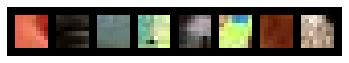

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

    plt.show()

# get some random training images
batch_maker = get_tile_batch(image_path_list,batch_size=8)
sample_images = next(batch_maker)

# show images
imshow(torchvision.utils.make_grid(sample_images))
# print labels

In [16]:
def train_autoencoder(epoch_size, train_loader,optimizer,model,criterion,max_epochs):
    training_loss_history= []
    loss = 0
    min_loss = 1
    for epoch_number,tiles in enumerate(train_loader):

        # reshape mini-batch data to [N, 3*8*8] matrix
        # load it to the active device
        tiles = tiles.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        outputs = model(tiles)                 # compute reconstructions
        train_loss = criterion(outputs, tiles.view(-1, 3*8*8)) # compute training reconstruction loss
        train_loss.backward()                  # compute accumulated gradients
        optimizer.step()                       # perform parameter update based on current gradients
        loss += train_loss.item()              # add the mini-batch training loss to epoch loss
        
        if epoch_number%epoch_size == epoch_size-1:
            # compute the epoch training loss
            loss = loss / epoch_size
            if loss < min_loss:
                min_loss = loss
                best_params = model.state_dict()
            # display the epoch training loss
            print(f"epoch : {(epoch_number+1)/epoch_size}, loss = {loss:.6f}")
            training_loss_history.append(loss)
            loss = 0
            if(epoch_number >= max_epochs):
                return best_params
                
    return 

In [17]:
c_vector_size = 10
net = AutoEncoder(hidden_sizes=[32*3,c_vector_size,32*3])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
batch_maker = get_tile_batch(image_path_list,tile_size=8,batch_size=1000)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [25]:
best_state_dict = train_autoencoder(10, batch_maker, optimizer, net, criterion,max_epochs=10000)
#net.load_state_dict(best_state_dict)

epoch : 1.0, loss = 0.011675
epoch : 2.0, loss = 0.011672
epoch : 3.0, loss = 0.011634
epoch : 4.0, loss = 0.011494
epoch : 5.0, loss = 0.011599
epoch : 6.0, loss = 0.011546
epoch : 7.0, loss = 0.011729
epoch : 8.0, loss = 0.011648
epoch : 9.0, loss = 0.011710
epoch : 10.0, loss = 0.011583
epoch : 11.0, loss = 0.011692
epoch : 12.0, loss = 0.011470
epoch : 13.0, loss = 0.011478
epoch : 14.0, loss = 0.011527
epoch : 15.0, loss = 0.011724
epoch : 16.0, loss = 0.011742
epoch : 17.0, loss = 0.011719
epoch : 18.0, loss = 0.011682
epoch : 19.0, loss = 0.011686
epoch : 20.0, loss = 0.011492
epoch : 21.0, loss = 0.011542
epoch : 22.0, loss = 0.011656
epoch : 23.0, loss = 0.011522
epoch : 24.0, loss = 0.011553
epoch : 25.0, loss = 0.011610
epoch : 26.0, loss = 0.011615
epoch : 27.0, loss = 0.011736
epoch : 28.0, loss = 0.011749
epoch : 29.0, loss = 0.011612
epoch : 30.0, loss = 0.011838
epoch : 31.0, loss = 0.011663
epoch : 32.0, loss = 0.011675
epoch : 33.0, loss = 0.011550
epoch : 34.0, loss 

In [26]:
models_path = os.path.join(wd_path, "models")

net.save_model(os.path.join(models_path, "ae10_0.pt"))

In [ ]:
# get some random training images
batch_maker = get_tile_batch(image_path_list,batch_size=1)
images = next(batch_maker)

images = images.to(device)
x_r = net.encode(images[0].view(3*8*8))
x_rebuilt_r = net.decode(x_r).detach().cpu().view(3,8,8)

# show images
imshow(torchvision.utils.make_grid(x_rebuilt_r))
print("Original")
imshow(images[0].detach().cpu().view(3,8,8))
# print labels

In [19]:
models_path = os.path.join(wd_path, "models")
loaded_autoencoder = AutoEncoder.load_autoencoder(os.path.join(models_path, "ae_0.pt"))
loaded_autoencoder.to(device)


AutoEncoder(
  (activation): ReLU()
  (fc1): Linear(in_features=192, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=96, bias=True)
  (fc4): Linear(in_features=96, out_features=192, bias=True)
)

Original
Reconstructed


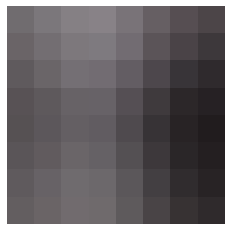

Original


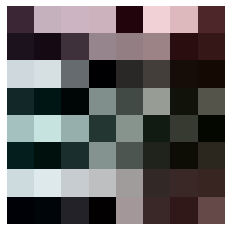

In [28]:
# get some random training images
batch_maker = get_tile_batch([os.path.join(wd_path, "images","val_0_0.jpeg")],batch_size=1)
images = next(batch_maker)
images = images.to(device)

print("Original")

x_r = loaded_autoencoder.encode(images.view(-1,3*8*8))
x_rebuilt_r = loaded_autoencoder.decode(x_r).detach().cpu().view(3,8,8)

print("Reconstructed")
# show images
imshow(x_rebuilt_r)
print("Original")

imshow(images[0].detach().cpu().view(3,8,8))
# print labels